In [71]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

product_data = pd.read_csv('../data/master_product_list.csv')

product_data['prod_subjectivity'] = product_data.apply(
    lambda row: TextBlob(str(row['product_details'])+' '+str(row['product_specs'])).subjectivity,  axis=1
)
product_data['prodSiteID'] = product_data['prodSiteID'].str.lower()
#review_data = pd.read_csv('../data/combined_review_table.csv')
review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')
review_data['prodSiteID'] = review_data['prodSiteID'].str.lower()
review_data = review_data.merge(
    right=product_data[['prodSiteID','prod_subjectivity']],
    how='left',on='prodSiteID'
)

review_data_base = pd.DataFrame(review_data)
train_data = pd.DataFrame(
    review_data[
        (review_data['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15])) &
        (review_data['review_lang']=='en') & 
        (review_data['site_outlier']==0)
    ]
)
train_data['prodSiteID'] = train_data['prodSiteID'].str.lower()

# train_data = train_data.merge(
#     right=product_data[['prodSiteID','prod_subjectivity']],
#     how='left',on='prodSiteID'
# )

display(train_data)
# train_data['prod_subjectivity'] = train_data.apply(
#     lambda row: 
#         product_data[
#             product_data['prodSiteID']==row['prodSiteID']
#         ]['prod_subjectivity'].iloc[0],
#     axis=1
# )

test_data = pd.DataFrame(
    review_data[
        (review_data['review_lang']=='en') & 
        (~review_data['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15]))
    ]
)
# test_data = test_data.merge(
#     right=product_data[['prodSiteID','prod_subjectivity']],
#     how='left',on='prodSiteID'
# )
   
review_metrics = pd.read_csv('../data/combined_review_metrics.csv')

C:\Users\pconn\AppData\Local\Temp\ipykernel_7472\1902485603.py:15: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')


,Unnamed: 0,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en,prod_subjectivity
0,0,1,amazon1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,49.0,NaN,en,Amazon,0,0,0,0,0.497845
1,1,1,amazon1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,24.0,NaN,en,Amazon,0,0,0,0,0.497845
2,2,1,amazon1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,66.0,NaN,en,Amazon,0,0,0,0,0.497845
4,4,1,amazon1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,31.0,NaN,en,Amazon,0,0,0,0,0.497845
5,5,1,amazon1,Better than new!,Love to sleep,This is my second iPhone purchase from Amazon ...,5,0,True,0.613068,0.402557,54.0,NaN,en,Amazon,0,0,0,0,0.497845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47456,47456,15,bb15,Personal traveling cooler,Zaggxr,"This cooler is very nice, it is Judy what I ne...",5,0,True,0.650000,0.390000,11.0,NaN,en,BestBuy,0,0,0,0,0.422341
47457,47457,15,bb15,IMX,RobertbC,The best cooler I have owned! Great on fishing...,5,0,True,0.525000,0.900000,10.0,NaN,en,BestBuy,0,0,0,0,0.422341
47459,47459,15,bb15,Great cooler for the money,AlexanderM,Fantastic cooler! Held temp longer than advert...,5,0,True,0.825000,0.650000,7.0,NaN,en,BestBuy,0,0,0,0,0.422341
47461,47461,15,bb15,Keep it cool,Tyrone6133,Thos cooler hereis the truth keeping items col...,5,0,True,0.825000,-0.125000,10.0,NaN,en,BestBuy,0,0,0,0,0.422341


In [72]:
train_data[train_data['prod_subjectivity'].isna()]['prodSiteID'].unique()

array([], dtype=object)

In [78]:
yAZ = np.sqrt(train_data[train_data['site']=='Amazon']['review_helpful_votes'])
XAZ = train_data[train_data['site']=='Amazon'][['verified_purchase','review_subjectivity','review_polarity','prod_subjectivity']]
regAZ = LinearRegression()
regAZ.fit(XAZ,yAZ)

yTg = np.sqrt(train_data[train_data['site']=='Target']['review_helpful_votes'])
XTg = train_data[train_data['site']=='Target'][['verified_purchase','review_subjectivity','review_polarity','prod_subjectivity']]
regTg = LinearRegression()
regTg.fit(XTg,yTg)

yBB = np.sqrt(train_data[train_data['site']=='BestBuy']['review_helpful_votes'])
XBB = train_data[train_data['site']=='BestBuy'][['verified_purchase','review_subjectivity','review_polarity','prod_subjectivity']]
regBB = LinearRegression()
regBB.fit(XBB,yBB)

regs = {
    'Amazon':regAZ,
    'BestBuy':regBB,
    'Target':regTg
}

In [79]:
def fit_reg(arr_vals,site):
    coefs = regs[site].coef_
    return np.sum(coefs * arr_vals,axis=1)

Tg_test_data = pd.DataFrame(test_data[test_data['site']=='Amazon'])
Tg_test_data['fitted_reg'] = fit_reg(test_data[test_data['site']=='Amazon'][['verified_purchase','review_subjectivity','review_polarity','prod_subjectivity']],'Amazon')

<Axes: xlabel='review_helpful_votes', ylabel='fitted_reg'>

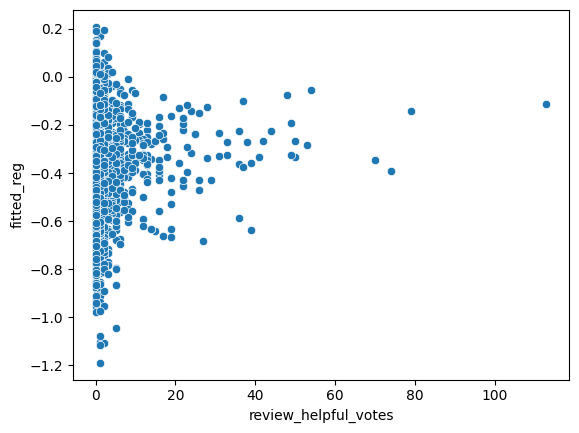

In [81]:
sns.scatterplot(
    data=Tg_test_data,
    x='review_helpful_votes',
    y='fitted_reg'    
)

In [38]:
np.sum(np.array([[1,2,3,4],[2,3,4,5]]) * np.array([[5,6,7,8],[6,7,8,9]]),axis=1)

array([ 70, 110])

<Axes: xlabel='review_helpful_votes', ylabel='fitted_reg'>

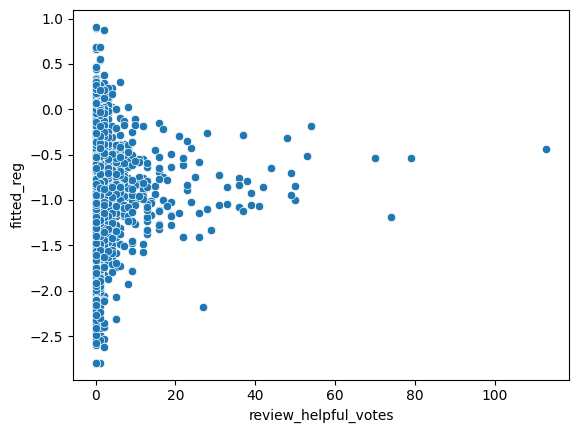

In [65]:
AZ_data = pd.DataFrame(review_data[review_data['site']=='Amazon'])
AZ_data['fitted_reg'] = fit_reg(AZ_data[AZ_data['site']=='Amazon'][['review_subjectivity','review_polarity','prod_subjectivity']],'Amazon')
sns.scatterplot(
    data=Tg_test_data,
    x='review_helpful_votes',
    y='fitted_reg'    
)

<Axes: xlabel='review_helpful_votes', ylabel='fitted_reg'>

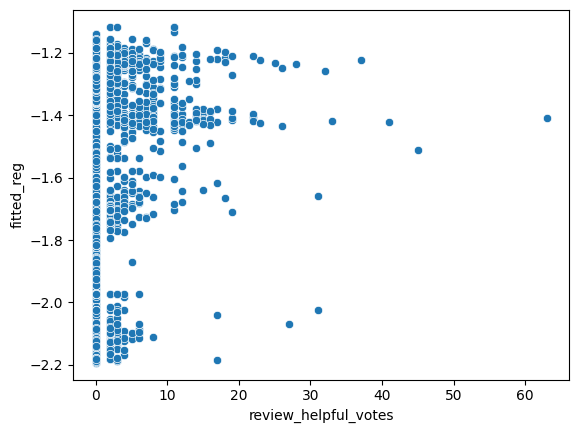

In [66]:
TG_data = pd.DataFrame(review_data[review_data['site']=='Target'])
TG_data['fitted_reg'] = fit_reg(TG_data[TG_data['site']=='Target'][['review_subjectivity','review_polarity','prod_subjectivity']],'Target')
sns.scatterplot(
    data=TG_data,
    x='review_helpful_votes',
    y='fitted_reg'    
)